*<h1 align='center'> Alexnet & Mobilenet models on MNIST - dataset </h1>*

---

Name: Logesh.V <br>
Email: vlogesh2001@gmail.com <br>

## Importing required packages

In [1]:
from tensorflow import keras
import matplotlib.pyplot as plt

import os
from tqdm import tqdm # to get progress bars while running
import time
import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from skimage.transform import resize
from keras.utils import np_utils

from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import MobileNet

import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

## Data Loading and Pre-Processing

In [2]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
# Normalization along with padding
train_images = tf.pad(train_images, [[0, 0], [2,2], [2,2]])/255
test_images = tf.pad(test_images, [[0, 0], [2,2], [2,2]])/255

# CLASSES
class_names = ['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']

# MNIST images are 28 x 28. The third axis is expanded and repeated 3 times to make image sizes 28 x 28 x 3
train_images = tf.expand_dims(train_images, axis=3, name=None)
test_images = tf.expand_dims(test_images, axis=3, name=None)
train_images = np.array(tf.repeat(train_images, 3, axis=3))
test_images = np.array(tf.repeat(test_images, 3, axis=3))

print(f'Shape of Test Data : {test_images.shape}')
print(f'Shape of Train Data : {train_images.shape}')

Shape of Test Data : (10000, 32, 32, 3)
Shape of Train Data : (60000, 32, 32, 3)


 Labels and their count :
 Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


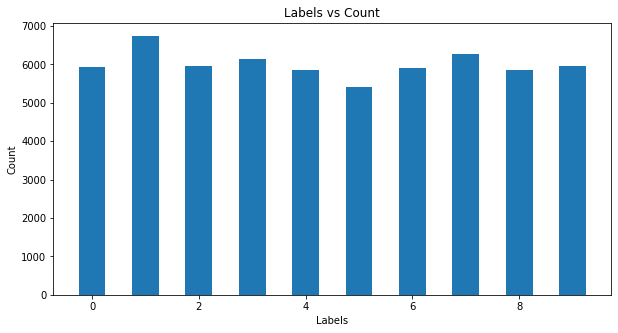

In [3]:
from collections import Counter
label_count = Counter(train_labels)
print(f' Labels and their count :\n {label_count}')

x = list(label_count.keys())
y = list(label_count.values())

fig = plt.figure(figsize = (10,5))
plt.bar(x,y,width = 0.5)
plt.title('Labels vs Count')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [4]:
test_images, validation_images, test_labels, validation_labels = train_test_split(test_images, test_labels, test_size=.5)

In [5]:
def dis_rand_exp(class_names, images, labels, x=5, y=10):
    fig = plt.figure(figsize = (20,10))
    fig.suptitle("Random Examples of Data-Set images", fontsize=24)
    for i in range(x*y):
        plt.subplot(x,y,i+1)
        plt.xticks([])
        plt.yticks([])
        rand = random.randint(0,len(images))
        plt.imshow(images[rand], cmap='gray')
        plt.xlabel(class_names[labels[rand]])
    plt.show()

### Primary preprocessing transformations
- Normalizing and standardizing the images.
- Resizing of the images from 28x28 to 227x227. The AlexNet network input expects a 227x227 image. </br>
`This will be implemented in Model as computation cost is individually`

In [6]:
# Default Image Size for all data
image_size = (227,227)
# below block for debuging purposes

### Shuffle the dataset

In [7]:
train_images,train_labels = shuffle(train_images,train_labels,random_state=random.randint(0, 10))
test_images,test_labels = shuffle(test_images,test_labels,random_state=random.randint(0, 10))
validation_images,validation_labels = shuffle(validation_images,validation_labels,random_state=random.randint(0, 10))

Training data size: (60000, 32, 32, 3)
Test data size: (5000, 32, 32, 3)
Validation data size: (5000, 32, 32, 3)


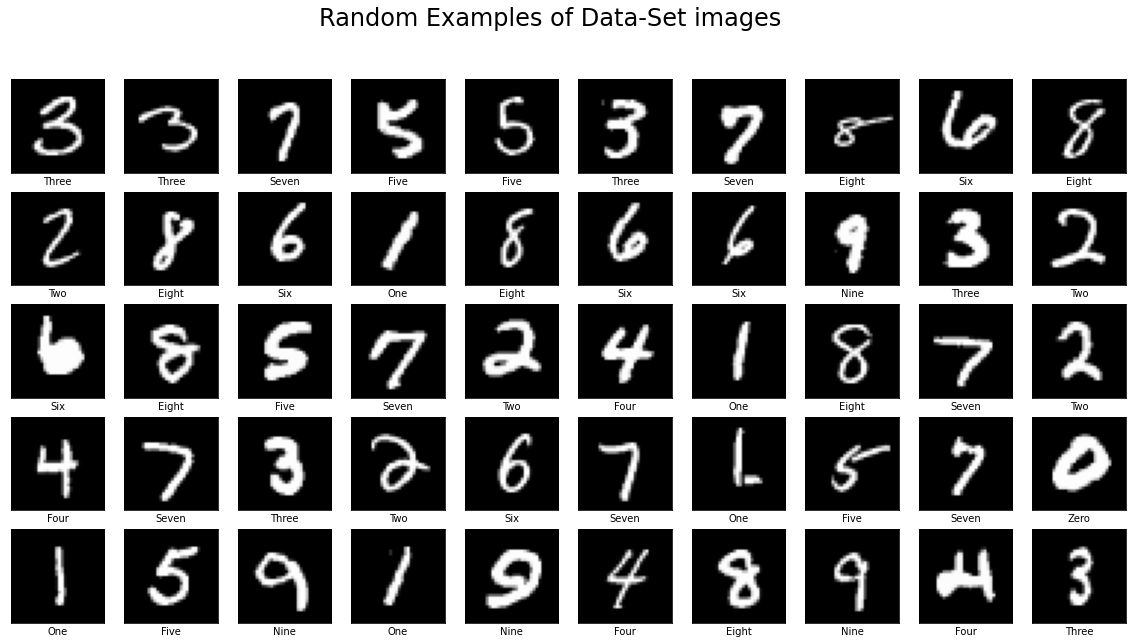

In [8]:
print("Training data size:", train_images.shape)
print("Test data size:", test_images.shape)
print("Validation data size:", validation_images.shape)
dis_rand_exp(class_names, np.float32(test_images), test_labels)

## ALEXNET - Model Implementation

In [9]:
tf.compat.v1.disable_eager_execution()
model = keras.models.Sequential([
    
    # Resizing pre-processing is done here
    keras.layers.experimental.preprocessing.Resizing(image_size[0], image_size[1], interpolation="bilinear", input_shape=train_images.shape[1:]),
    
    # 1st-Layer
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=image_size),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    # 2nd-Layer
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    # 3rd-Layer
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    
    # FC layer 
    keras.layers.Flatten(),
    
    # DNN
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    
    # Output
    keras.layers.Dense(10, activation='softmax')
])

Instructions for updating:
Colocations handled automatically by placer.


## Training and Results - ALEXNET

In [10]:
# Compling our Model-ALEXNET
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.optimizers.SGD(lr=0.001), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 256)       1024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 256)         0

d:\studies\workspaces\python\compiler\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [11]:
epochs = 10
history = model.fit(train_images,
                    train_labels,
                    epochs=epochs,
                    #steps_per_epoch=100, # reduced no.of steps per epoch
                    batch_size=32, # default batch size is 32, low for reduced gpu memory
                    validation_data=(validation_images,validation_labels),
                    validation_freq=1,
                   )

Train on 60000 samples, validate on 5000 samples
Epoch 1/10
60000/60000 [==============================] - ETA: 0s - loss: 0.3248 - accuracy: 0.8984

d:\studies\workspaces\python\compiler\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


60000/60000 [==============================] - 89s 1ms/sample - loss: 0.3248 - accuracy: 0.8984 - val_loss: 0.0603 - val_accuracy: 0.9804
Epoch 2/10
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.0833 - accuracy: 0.9744 - val_loss: 0.0455 - val_accuracy: 0.98480834 - accuracy: 0.
Epoch 3/10
60000/60000 [==============================] - 93s 2ms/sample - loss: 0.0574 - accuracy: 0.9825 - val_loss: 0.0341 - val_accuracy: 0.9884
Epoch 4/10
60000/60000 [==============================] - 88s 1ms/sample - loss: 0.0447 - accuracy: 0.9865 - val_loss: 0.0312 - val_accuracy: 0.9898
Epoch 5/10
60000/60000 [==============================] - 90s 1ms/sample - loss: 0.0351 - accuracy: 0.9890 - val_loss: 0.0292 - val_accuracy: 0.9906
Epoch 6/10
60000/60000 [==============================] - 89s 1ms/sample - loss: 0.0302 - accuracy: 0.9908 - val_loss: 0.0299 - val_accuracy: 0.9892
Epoch 7/10
60000/60000 [==============================] - 90s 1ms/sample - loss: 0.0262 - accuracy

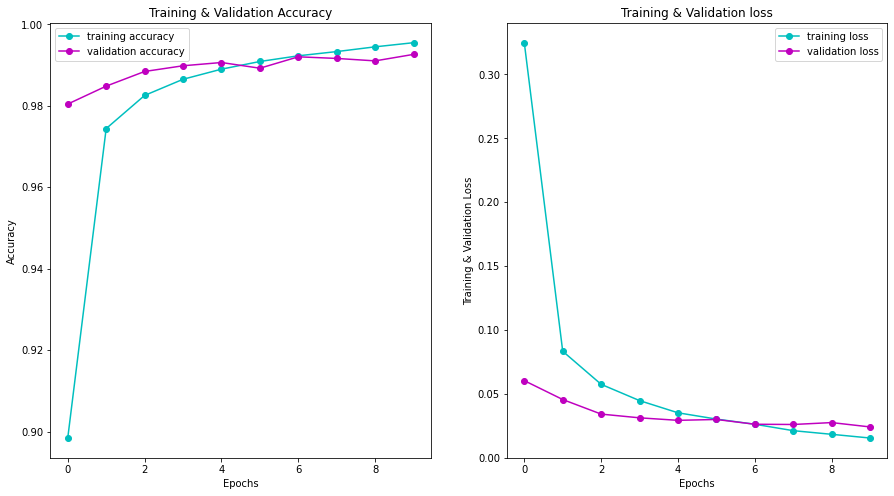

In [12]:
def plot_accuracy_and_loss_of_train_and_validation_dataset(history):
    epoch=[i for i in range(epochs)]
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(15,8)
    ax[0].plot(epoch,train_acc,'co-',label='training accuracy')
    ax[0].plot(epoch,val_acc,'mo-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epoch,train_loss,'c-o',label='training loss')
    ax[1].plot(epoch,val_loss,'m-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

plot_accuracy_and_loss_of_train_and_validation_dataset(history)

## Evaluation

In [13]:
model.evaluate(test_images, test_labels)

[0.019261381610330044, 0.9932]

In [14]:
loss,accuracy = model.evaluate(test_images,test_labels)
print("The accuracy of test image is : ",accuracy)

The accuracy of test image is :  0.9932


### Accuracy for each class

In [15]:
print("Predicting Test Images using the above Trained model...")
pred_Ids_of_test = model.predict(test_images)

Predicting Test Images using the above Trained model...


In [16]:
predIdxs = np.argmax(pred_Ids_of_test, axis=1) # to get the indices of max value in each row
print(classification_report(test_labels, predIdxs,target_names=class_names))

              precision    recall  f1-score   support

        Zero       0.99      1.00      0.99       462
         One       0.99      1.00      1.00       564
         Two       0.99      1.00      0.99       517
       Three       1.00      0.99      1.00       494
        Four       0.99      0.99      0.99       495
        Five       0.99      1.00      0.99       455
         Six       1.00      0.99      0.99       510
       Seven       0.99      0.99      0.99       491
       Eight       0.99      0.99      0.99       480
        Nine       0.99      0.98      0.99       532

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



### Confusion Matrix

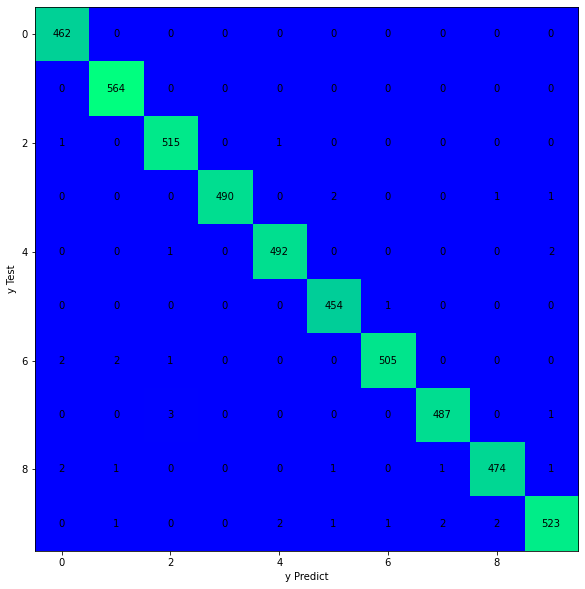

In [17]:
CM = confusion_matrix(test_labels, predIdxs)
# Plot confusion matrix
plt.figure(figsize = (10,10))
plt.imshow(CM,interpolation='nearest',cmap='winter')
for (i, j), z in np.ndenumerate(CM):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y Test")
plt.grid(False)
plt.show()

In [18]:
# Class-wise Precision
acc={}
l=len(CM)
for i in range(0,l):
    acc[class_names[i]]=CM[i][i]/sum(CM[:, i])
print("Class-wise accuracy from Confusion Matrix. Format --> Class: ACCURACY\n",acc)

Class-wise accuracy from Confusion Matrix. Format --> Class: ACCURACY
 {'Zero': 0.9892933618843683, 'One': 0.9929577464788732, 'Two': 0.9903846153846154, 'Three': 1.0, 'Four': 0.9939393939393939, 'Five': 0.9912663755458515, 'Six': 0.9960552268244576, 'Seven': 0.9938775510204082, 'Eight': 0.9937106918238994, 'Nine': 0.990530303030303}


## MOBILENET - Model Implementation

### Encoding labels
One-hot encoding can be applied to the label integer representation. This is where the integer encoded variable is removed and a new binary variable is added for each unique integer value.

In [6]:
n_classes = len(class_names)
# one-hot encoding using keras' numpy-related utilities
print("Shape before one-hot encoding: (Training) ", train_labels.shape)
train_labels0 = np_utils.to_categorical(train_labels, n_classes)
test_labels0 = np_utils.to_categorical(test_labels, n_classes)
validation_labels0 = np_utils.to_categorical(validation_labels, n_classes)
print("Shape after one-hot encoding: (Training) ", train_labels0.shape)

Shape before one-hot encoding: (Training)  (60000,)
Shape after one-hot encoding: (Training)  (60000, 10)


In [7]:
# Mobile Net Model creation
base_model = MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last dense layer (size 1000)

# For better results
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Adding Dense layers to base model of mobilenet
x = Dense(1024,activation='relu')(x) 
x = Dense(1024,activation='relu')(x) 
x = Dense(512,activation='relu')(x) 

# Final output layer with softmax activation
preds = Dense(train_labels0.shape[1],activation='softmax')(x) 

# Creating the model and compiling it
model = Model(inputs = base_model.input, outputs = preds)

## Training and Results - MOBILENET

In [8]:
# Compling our Model-MOBILENET
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
conv1 (Conv2D)               (None, None, None, 32)    864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, None, None, 32)    128       
_________________________________________________________________
conv1_relu (ReLU)            (None, None, None, 32)    0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)    288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, None, None, 32)    128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, None, None, 32)    0     

In [9]:
epochs = 20

history = model.fit(train_images,
                    train_labels0,
                    epochs=epochs,
                    #steps_per_epoch=100, # reduced no.of steps per epoch
                    batch_size=32, # default batch size is 32, low for reduced gpu memory
                    validation_data=(validation_images,validation_labels0))

Epoch 1/20
1875/1875 [==============================] - 43s 20ms/step - loss: 0.3108 - accuracy: 0.9259 - val_loss: 0.2285 - val_accuracy: 0.9518
Epoch 2/20
1875/1875 [==============================] - 37s 20ms/step - loss: 0.1503 - accuracy: 0.9680 - val_loss: 0.0887 - val_accuracy: 0.9798
Epoch 3/20
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1425 - accuracy: 0.9705 - val_loss: 0.0615 - val_accuracy: 0.9870
Epoch 4/20
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1043 - accuracy: 0.9785 - val_loss: 0.0775 - val_accuracy: 0.9840
Epoch 5/20
1875/1875 [==============================] - 36s 19ms/step - loss: 0.1001 - accuracy: 0.9787 - val_loss: 0.0609 - val_accuracy: 0.9866
Epoch 6/20
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0889 - accuracy: 0.9816 - val_loss: 0.0562 - val_accuracy: 0.9876
Epoch 7/20
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0818 - accuracy: 0.9822 - val_loss: 0.0565 -

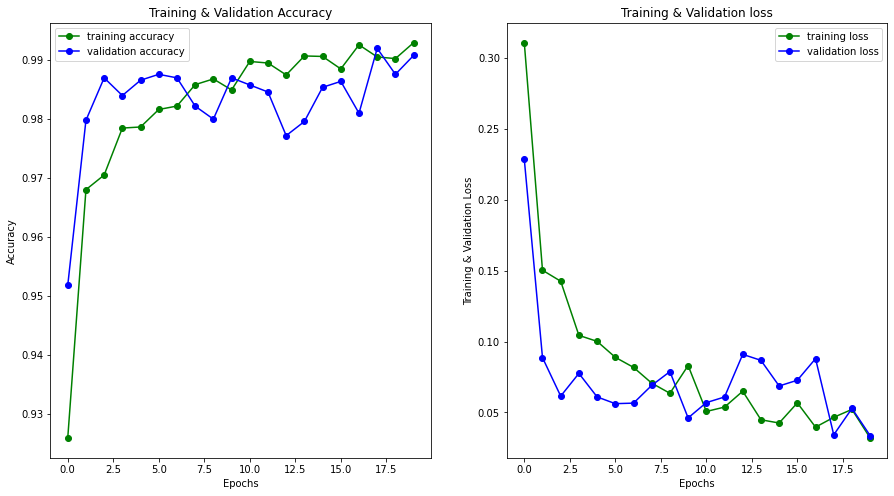

In [11]:
def plot_accuracy_and_loss_of_train_and_validation_dataset(history):
    epoch=[i for i in range(epochs)]
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(15,8)
    ax[0].plot(epoch,train_acc,'go-',label='training accuracy')
    ax[0].plot(epoch,val_acc,'bo-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epoch,train_loss,'g-o',label='training loss')
    ax[1].plot(epoch,val_loss,'b-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

plot_accuracy_and_loss_of_train_and_validation_dataset(history)

In [12]:
loss,accuracy = model.evaluate(test_images,test_labels0)
print("The accuracy of test image is : ",accuracy)

157/157 [==============================] - 2s 9ms/step - loss: 0.0310 - accuracy: 0.9926
The accuracy of test image is :  0.9926000237464905


### Accuracy for each class

In [13]:
print("Predicting Test Images using the above Trained model...")
pred_Ids_of_test = model.predict(test_images)

Predicting Test Images using the above Trained model...


In [14]:
predIdxs = np.argmax(pred_Ids_of_test, axis=1) # to get the indices of max value in each row
print(classification_report(test_labels, predIdxs,target_names=class_names))

              precision    recall  f1-score   support

        Zero       1.00      0.99      0.99       507
         One       0.98      1.00      0.99       564
         Two       1.00      0.99      1.00       524
       Three       0.99      0.99      0.99       500
        Four       0.99      1.00      1.00       470
        Five       0.99      0.99      0.99       452
         Six       0.99      1.00      0.99       455
       Seven       1.00      0.99      0.99       519
       Eight       1.00      0.98      0.99       491
        Nine       0.99      0.99      0.99       518

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



### Confusion Matrix

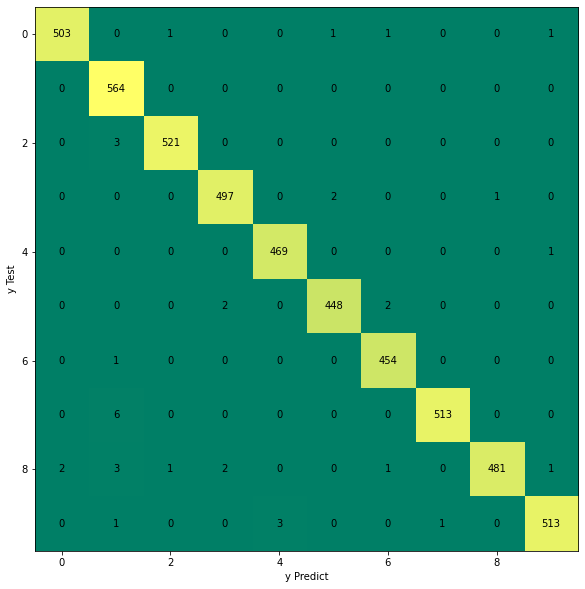

In [15]:
CM = confusion_matrix(test_labels, predIdxs)
# Plot confusion matrix
plt.figure(figsize = (10,10))
plt.imshow(CM,interpolation='nearest',cmap='summer')
for (i, j), z in np.ndenumerate(CM):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y Test")
plt.grid(False)
plt.show()

In [16]:
# Class-wise Precision
acc={}
l=len(CM)
for i in range(0,l):
    acc[class_names[i]]=CM[i][i]/sum(CM[:, i])
print("Class-wise accuracy from Confusion Matrix. Format --> Class: ACCURACY\n",acc)

Class-wise accuracy from Confusion Matrix. Format --> Class: ACCURACY
 {'Zero': 0.996039603960396, 'One': 0.9757785467128027, 'Two': 0.9961759082217974, 'Three': 0.9920159680638723, 'Four': 0.9936440677966102, 'Five': 0.9933481152993349, 'Six': 0.9912663755458515, 'Seven': 0.9980544747081712, 'Eight': 0.9979253112033195, 'Nine': 0.9941860465116279}


---
#### *<div style="text-align: center"> - - - - - Thank You - - - - - <div>*
---